- https://www.kaggle.com/c/tabular-playground-series-feb-2021/code?competitionId=25225&searchQuery=fast
- https://www.kaggle.com/martinmarenz/tune-fast-ai-with-optuna-feb-playground

# Imports

In [2]:
import fastai
import optuna

from fastai.tabular.all import *
from optuna.integration import FastAIV2PruningCallback

print("Fast.ai:", fastai.__version__)
print("Optuna:", optuna.__version__)

Fast.ai: 2.3.1
Optuna: 2.7.0


# <center> PART 1: Self Supervised (DAE)
- https://walkwithfastai.com/tab.ae
- https://github.com/EtienneT/TabularVAE

# <center> PART 2: Supervised

# ADULT Dataset

In [2]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
print("TRAIN:", df.shape)

to = TabularPandas(df,
                   procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=RandomSplitter(valid_pct=0.2,seed=42)(range_of(df)))

dls = to.dataloaders(bs=64)

TRAIN: (32561, 15)


In [4]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Prof-school,Separated,Prof-specialty,Not-in-family,White,False,46.0,249685.999557,15.0,>=50k
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,False,45.0,123681.003103,13.0,<50k
2,Private,HS-grad,Never-married,Sales,Not-in-family,White,False,20.0,296618.001521,9.0,<50k
3,Private,Assoc-acdm,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,False,33.0,355855.999538,12.0,<50k
4,Private,11th,Divorced,Craft-repair,Own-child,White,False,54.0,225306.999269,7.0,>=50k
5,Private,5th-6th,Divorced,Transport-moving,Unmarried,White,False,45.0,96797.999461,3.0,<50k
6,Private,Some-college,Married-civ-spouse,Sales,Husband,White,False,28.0,206350.999369,10.0,<50k
7,Self-emp-not-inc,Some-college,Married-civ-spouse,Tech-support,Husband,Black,False,47.0,180446.000304,10.0,>=50k
8,Local-gov,10th,Never-married,Other-service,Own-child,White,False,17.0,39815.003558,6.0,<50k
9,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,Amer-Indian-Eskimo,False,44.0,33105.005245,9.0,<50k


In [5]:
"""
class Dense(nn.Sequential):
    "Module grouping `BatchNorm1d`, `Dropout` and `Linear` layers"
    def __init__(self, n_in, n_out, batch_norm=True, dropout=0., act_fn=nn.ReLU(inplace=True)):
        layers = []
        if batch_norm:  layers.append(BatchNorm(n_in, ndim=1))
        if dropout > 0: layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(n_in, n_out, bias=not batch_norm) )
        if act_fn:      layers.append(act_fn)
        super().__init__(*layers)
"""
    
class ResidualDense(Module):
    
    def __init__(self, n_dim, batch_norm, dropout, act_fn, lin_first):    
        self.block = LinBnDrop(n_in  = n_dim,
                               n_out = n_dim,
                               bn    = batch_norm,
                               p     = dropout,
                               act   = act_fn,
                               lin_first = lin_first)
        
    def forward(self, x):
        return x + self.block(x)
    
    
class ResidualTabularModel(Module):

    def __init__(self, emb_szs, cont_sz, hid_sz, out_sz, num_layers, emb_drop=0., dropout=0.,
                 y_range=None, batch_norm=True, bn_cont=True, act_fn=nn.ReLU(inplace=True),
                 lin_first=False):
        
        ######################################### EMBEDDINGS LAYERS
        # emb_szs = [("catA",4,2), ("catB",17,8)]
        # self.embeds = nn.ModuleDict({var_name: Embedding(num_i, num_o,) for var_name,num_i,num_o in emb_szs})
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        
        ######################################### CONT LAYERS
        self.bn_cont = nn.BatchNorm1d(cont_sz) if bn_cont else None
        
        ######################################### FIRST DENSE LAYER
        #input_sz = cont_sz + sum(e.embedding_dim for e in self.embeds.values())
        self.n_emb  = sum(e.embedding_dim for e in self.embeds)
        self.n_cont = cont_sz
        input_sz = self.n_emb + self.n_cont
        if hid_sz < input_sz:
            raise Exception('hid_sz sholud be large than input_sz')
        
        self.firstDense = LinBnDrop(n_in  = input_sz,
                                    n_out = hid_sz - input_sz,
                                    bn    = batch_norm,
                                    p     = dropout,
                                    act   = act_fn,
                                    lin_first = lin_first)

        ######################################### RESIDUIAL LAYERS
        self.residual_layers = nn.Sequential(
            *[ ResidualDense(n_dim      = hid_sz,
                             batch_norm = batch_norm,
                             dropout    = dropout,
                             act_fn     = act_fn,
                             lin_first  = lin_first) for i in range(num_layers) ])
        
        ######################################### FINAL DENSE LAYER
        self.finalDense = LinBnDrop(n_in  = hid_sz,
                                    n_out = out_sz,
                                    bn    = False,
                                    p     = 0.,
                                    act   = None,
                                    lin_first = lin_first)
        
    def forward(self, x_cat, x_cont=None):
        
        if self.n_emb != 0:
            x = [emb(x_cat[:,i]) for i,emb in enumerate(self.embeds)] # Get embeddings
            x = torch.cat(x, 1)    # Concat embeddings
            x = self.emb_drop(x)
        if self.n_cont != 0:
            if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont # Concat numerical feats
        
        x = torch.cat([x, self.firstDense(x)], 1) # Concat embeddings + numerical feats
        x = self.residual_layers(x)
        x = self.finalDense(x)
        
        return x

# Default Sequnetial model

In [6]:
model = TabularModel(emb_szs = get_emb_sz(dls.train_ds),
                     n_cont = len(dls.cont_names),
                     out_sz = get_c(dls),
                     layers = [200,200], # [2000,1000], # [2000,500],
                     ps     = 0.2,
                     #y_range=None,
                     #embed_p=0.20,
                     #ps=0.30,
                     #act_cls=nn.GELU() #nn.LeakyReLU() Swish(), # ReLU(inplace=True), Swish(), Mish()
                    )

learn = TabularLearner(dls,
                       model,
                       metrics=[accuracy]) # rmse

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.0020892962347716093)

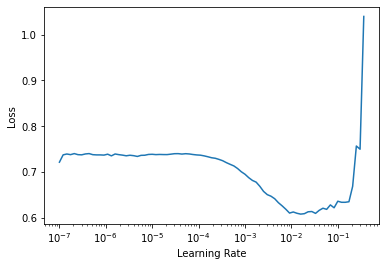

In [7]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(5, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.395472,0.413166,0.809889,00:02
1,0.381816,0.367114,0.831849,00:02
2,0.365710,0.355101,0.837684,00:02
3,0.365361,0.354054,0.836456,00:02
4,0.353902,0.349850,0.838298,00:02


In [9]:
learn.fit_one_cycle(10, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.383468,0.386974,0.830006,00:03
1,0.394717,0.367257,0.826321,00:02
2,0.373586,0.375887,0.835534,00:02
3,0.372801,0.363915,0.834920,00:02
4,0.375162,0.368258,0.835534,00:02
5,0.355847,0.351275,0.838759,00:02
6,0.358697,0.352327,0.837377,00:02
7,0.353268,0.349005,0.839681,00:02
8,0.347536,0.347869,0.841677,00:02
9,0.360882,0.347358,0.841984,00:02


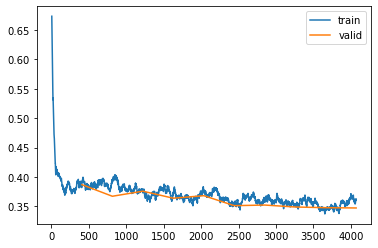

In [18]:
learn.recorder.plot_loss()

# Residual version

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.019054606556892395)

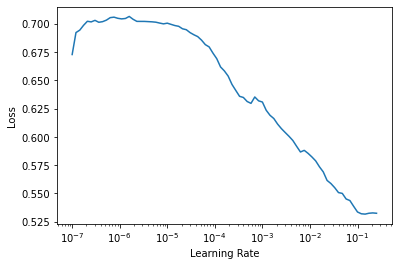

In [12]:
resModel = ResidualTabularModel(emb_szs = get_emb_sz(dls.train_ds),
                                cont_sz = len(dls.cont_names),
                                hid_sz  = 200,
                                out_sz  = get_c(dls),
                                dropout = 0.2,
                                num_layers = 6,
                                batch_norm=False, bn_cont=False)

reslearn = TabularLearner(dls,
                          resModel,
                          metrics=[accuracy],  # rmse
                          wd=None)

reslearn.lr_find()

In [13]:
reslearn.fit_one_cycle(10, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.367883,0.359608,0.836609,00:03
1,0.376368,0.367855,0.828778,00:03
2,0.369909,0.359103,0.830927,00:03
3,0.365991,0.365757,0.830620,00:03
4,0.362679,0.356184,0.836149,00:03
5,0.348500,0.354459,0.832463,00:03
6,0.352772,0.351175,0.840756,00:03
7,0.342894,0.349477,0.841677,00:03
8,0.350022,0.349223,0.840141,00:03
9,0.337893,0.348839,0.841370,00:03


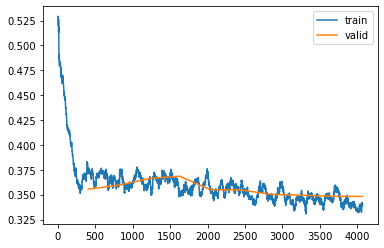

In [33]:
reslearn.recorder.plot_loss()

# Tabular feb21 Dataset

In [3]:
df = pd.read_csv("data/train.csv", index_col="id")
test_df = pd.read_csv("data/test.csv", index_col="id")

print("TRAIN:", df.shape)
print("TEST:", test_df.shape)

to = TabularPandas(df         = df,
                   procs      = [Categorify, Normalize],
                   cat_names  = ["cat"+str(i) for i in range(10)],
                   cont_names = ["cont"+str(i) for i in range(14)],
                   y_names    = 'target',
                   splits     = RandomSplitter(valid_pct=0.25, seed=42)(df.index))

dls = to.dataloaders(bs=64)

TRAIN: (300000, 25)
TEST: (200000, 24)


In [6]:
model = TabularModel(emb_szs = get_emb_sz(dls.train_ds),
                     n_cont = len(dls.cont_names),
                     out_sz = get_c(dls),
                     layers = [200,200], # [2000,1000], # [2000,500],
                     ps     = 0.2,
                     #y_range=None,
                     #embed_p=0.20,
                     #ps=0.30,
                     #act_cls=nn.GELU() #nn.LeakyReLU() Swish(), # ReLU(inplace=True), Swish(), Mish()
                    )

learn = TabularLearner(dls,
                       model,
                       metrics=[rmse]) # 

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=3.0199516913853586e-05)

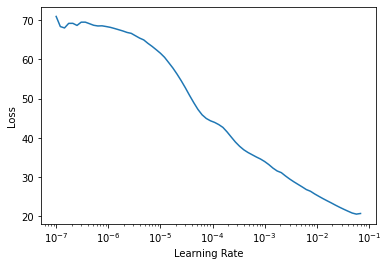

In [7]:
resModel = ResidualTabularModel(emb_szs = get_emb_sz(dls.train_ds),
                                cont_sz = len(dls.cont_names),
                                hid_sz  = 1000,
                                out_sz  = get_c(dls),
                                dropout = 0.3,
                                num_layers = 8,
                                batch_norm=False, bn_cont=False)

reslearn = TabularLearner(dls,
                          resModel,
                          metrics=[rmse],  # rmse
                          wd=None)

reslearn.lr_find()

In [8]:
reslearn.fit_one_cycle(10, lr_max=1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,0.822312,0.780543,0.883484,00:32
1,0.800528,0.755533,0.869214,00:32
2,0.759984,0.758197,0.870745,00:32
3,0.775231,0.753489,0.868038,00:32
4,0.749304,0.760711,0.872187,00:32
5,0.751493,0.767773,0.876227,00:32
6,0.743316,0.749541,0.865761,00:32
7,0.747567,0.744768,0.863000,00:33
8,0.716393,0.744393,0.862782,00:34
9,0.745593,0.741862,0.861314,00:34


In [7]:
reslearn.fit_one_cycle(10, lr_max=1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,0.814532,0.823697,0.907578,00:27
1,0.761123,0.758450,0.870891,00:27
2,0.763733,0.793136,0.890582,00:27
3,0.785560,0.755294,0.869077,00:27
4,0.757074,0.753606,0.868104,00:27
5,0.755032,0.748277,0.865030,00:27
6,0.787666,0.744098,0.862611,00:27
7,0.770914,0.745264,0.863286,00:27
8,0.744689,0.740873,0.860740,00:27
9,0.745604,0.740523,0.860536,00:27


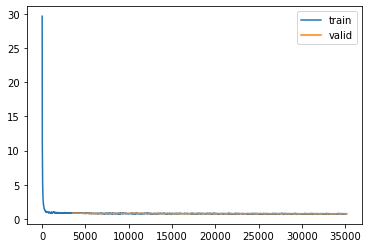

In [9]:
reslearn.recorder.plot_loss()

In [11]:
learn.fit_one_cycle(30, lr_max=1e-3)

epoch,train_loss,valid_loss,_rmse,time
0,0.886616,0.821616,0.906430,00:24
1,0.887449,0.843562,0.918457,00:24
2,0.869391,0.872484,0.934068,00:24
3,0.874995,0.802659,0.895912,00:24
4,0.840453,0.776164,0.881001,00:24
5,0.836687,0.765945,0.875183,00:24
6,0.842000,0.785742,0.886421,00:24
7,0.847312,0.771673,0.878449,00:24
8,0.815588,0.809959,0.899978,00:24
9,0.795340,0.767613,0.876135,00:24


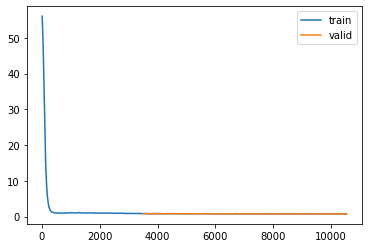

In [26]:
learn.recorder.plot_loss()